## Bounding Boxes Convolution Network Training
I love buzzwords.


In [1]:
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import cv2

%matplotlib inline

Using Theano backend.
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.13-64/tmpuywbd5/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.13-64/tmpuywbd5/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5005)


In [2]:
%load_ext autoreload
%autoreload 2
import sys
paths = ['../models', '../dataset', '../util']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
 
from bounding_boxes import *
from data_generators import get_data_with_bbox_coords
import dataset
from callbacks import ShowSegmentation

bboxes = get_bounding_boxes('../data')
bboxes = largest_bbox_per_image(bboxes)
train_data = dataset.train
val_data = dataset.validation
 
train_gen = get_data_with_bbox_coords(train_data, '../data/train', bboxes)
val_gen = get_data_with_bbox_coords(val_data, '../data/train', bboxes)
n_labels = len(dataset.labels)

Function to define the layers of the convnet.

In [3]:
def keras_model_conv():
    model = Sequential()
    
    model.add(BatchNormalization(axis=1,  input_shape=(3, 256, 256)))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu',))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.50))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.50))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.50))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))

    model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['accuracy', 'mse'])

    return model

Initialization of the model.

In [4]:
model = keras_model_conv()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 3, 256, 256)   12          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 256, 256)  448         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 16, 256, 256)  64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 128, 128)  0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

Fit the model using a generator.

Use: 
fit_generator(self, generator, samples_per_epoch, nb_epoch, verbose=1, callbacks=None, validation_data=None, nb_val_samples=None, class_weight=None, max_q_size=10, nb_worker=1, pickle_safe=False, initial_epoch=0)


In [5]:
model.fit_generator(train_gen, samples_per_epoch=len(train_data),
                    nb_epoch=2, verbose=1,
                    callbacks=None,
                    validation_data=val_gen, nb_val_samples=len(val_data))

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.13-64/tmpobvs8c/e27d3604e20e1a2d817586b7e9b57f6e.lib and object C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.13-64/tmpobvs8c/e27d3604e20e1a2d817586b7e9b57f6e.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.13-64/tmpt8r_qh/983200c50d11ea510f69ec02b378288e.lib and object C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.13-64/tmpt8r_qh/983200c50d11ea510f69ec02b378288e.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/The Mountain/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-Intel64_Family_6_Model_60_Stepping_

Epoch 1/2
3008/3021 [============================>.] - ETA: 0s - loss: 1118.7787 - acc: 0.7224 - mean_squared_error: 1118.7787  

C:\Anaconda2\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


3040/3021 [==============================] - 76s - loss: 1114.5598 - acc: 0.7240 - mean_squared_error: 1114.5598 - val_loss: 2508.2153 - val_acc: 0.4062 - val_mean_squared_error: 2508.2152
Epoch 2/2
3040/3021 [==============================] - 69s - loss: 577.8000 - acc: 0.7977 - mean_squared_error: 577.8000 - val_loss: 1853.1291 - val_acc: 0.5026 - val_mean_squared_error: 1853.1290

In [80]:
model.fit_generator(train_gen, samples_per_epoch=len(train_data),
                    nb_epoch=50, verbose=1,
                    callbacks=None,
                    validation_data=val_gen, nb_val_samples=len(val_data),nb_worker=3)

Epoch 1/50
3040/3021 [==============================] - 68s - loss: 156.7464 - acc: 0.9220 - mean_squared_error: 156.7464 - val_loss: 311.4101 - val_acc: 0.9180 - val_mean_squared_error: 311.4101
Epoch 2/50
3040/3021 [==============================] - 62s - loss: 148.9702 - acc: 0.9148 - mean_squared_error: 148.9702 - val_loss: 416.5046 - val_acc: 0.8906 - val_mean_squared_error: 416.5046
Epoch 3/50
3040/3021 [==============================] - 62s - loss: 155.3038 - acc: 0.9207 - mean_squared_error: 155.3038 - val_loss: 333.6157 - val_acc: 0.9010 - val_mean_squared_error: 333.6157
Epoch 4/50
3040/3021 [==============================] - 63s - loss: 151.9810 - acc: 0.9329 - mean_squared_error: 151.9810 - val_loss: 238.2060 - val_acc: 0.9115 - val_mean_squared_error: 238.2060
Epoch 5/50
3040/3021 [==============================] - 62s - loss: 156.0924 - acc: 0.9188 - mean_squared_error: 156.0924 - val_loss: 267.7204 - val_acc: 0.9010 - val_mean_squared_error: 267.7204
Epoch 6/50
3040/3021

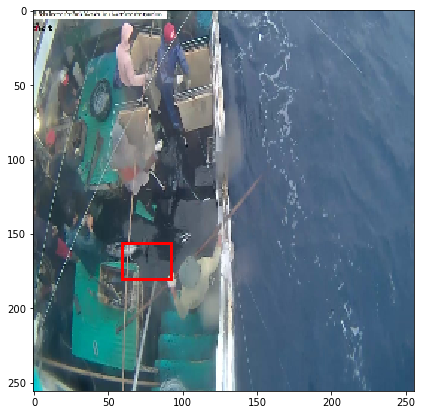

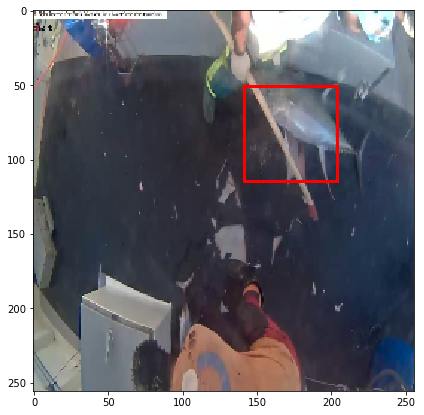

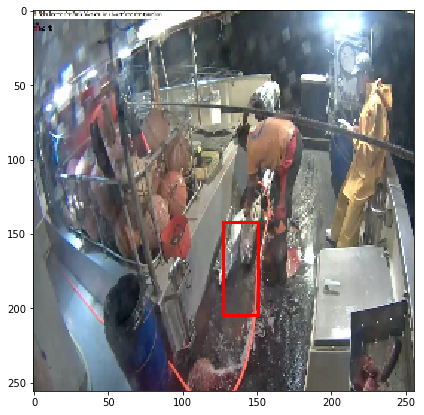

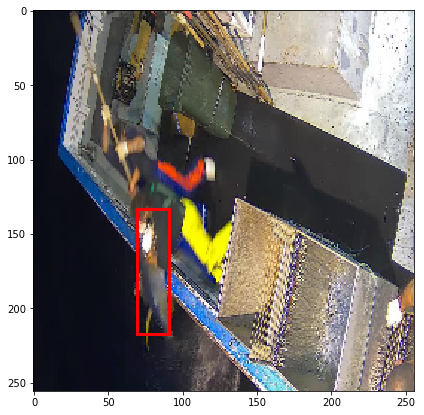

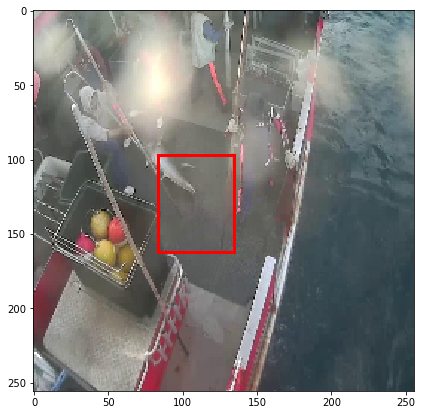

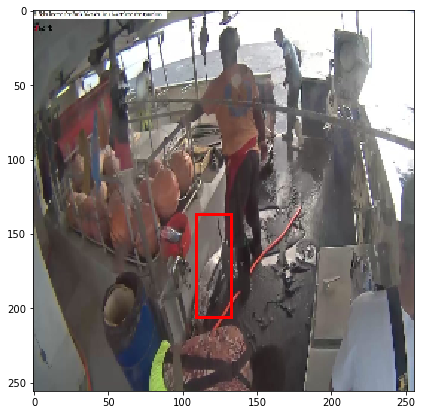

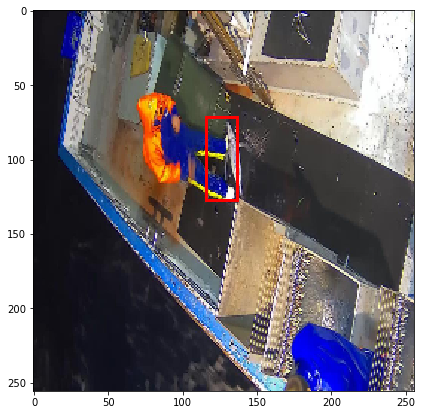

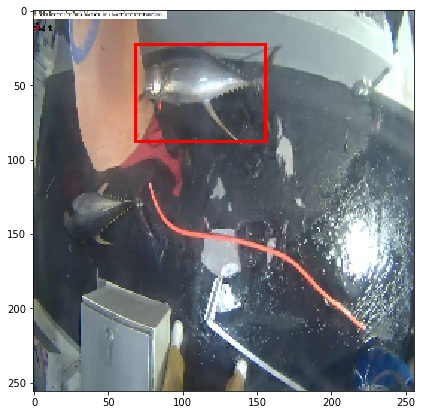

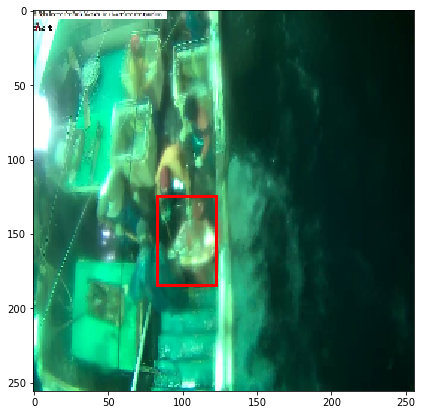

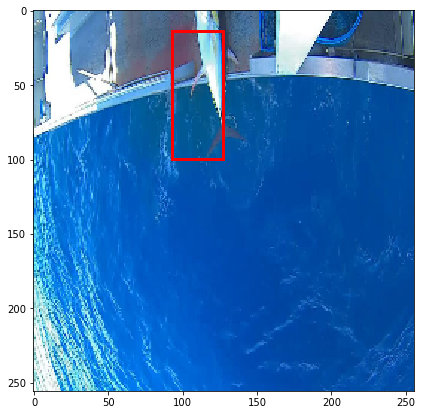

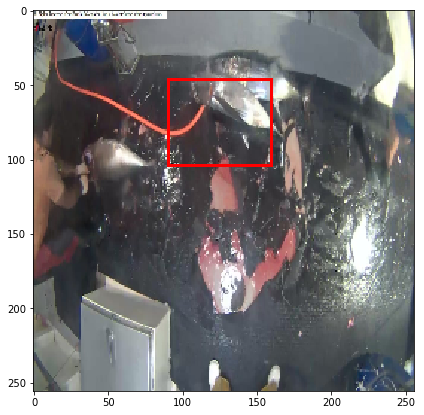

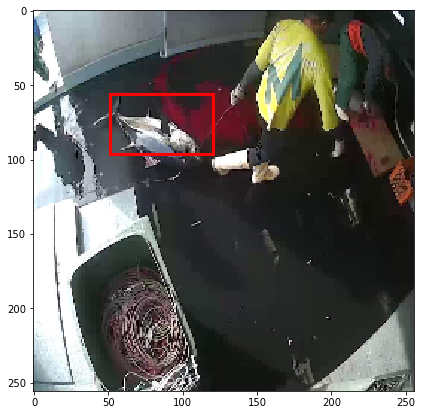

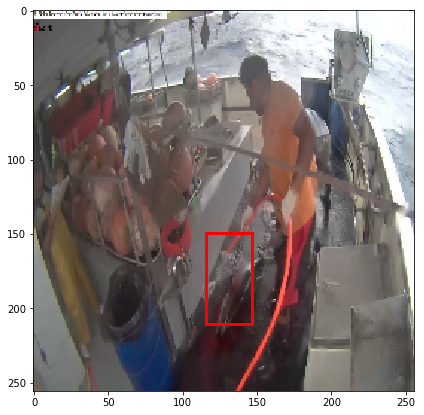

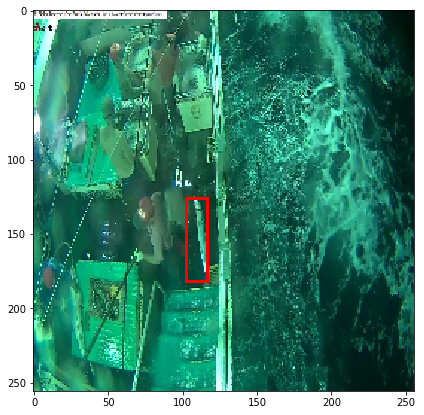

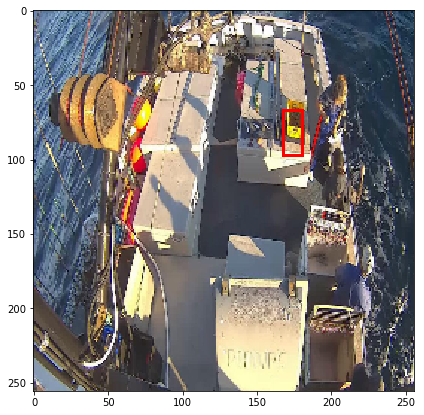

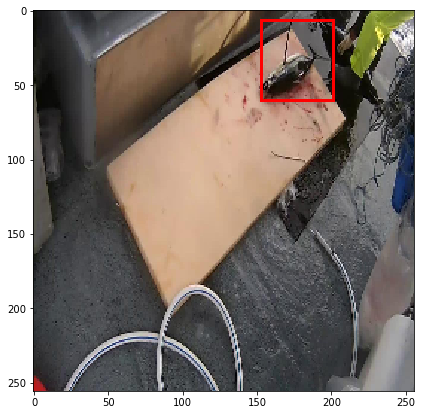

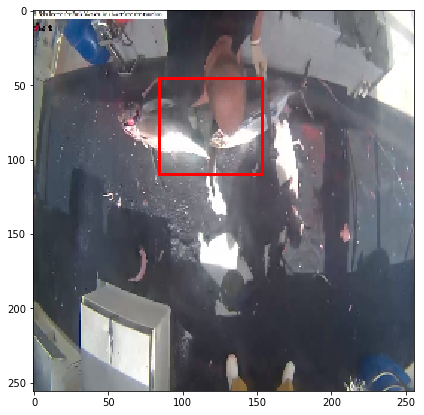

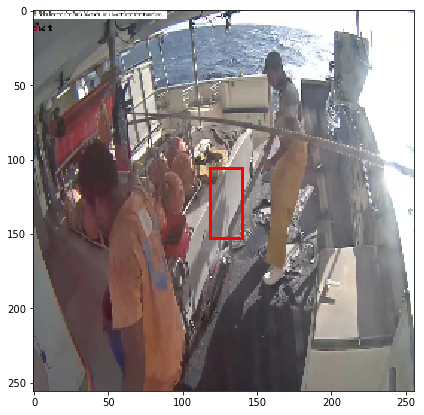

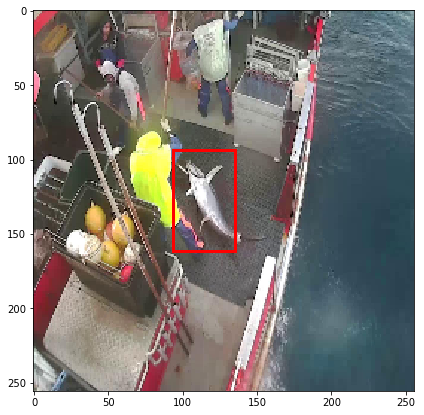

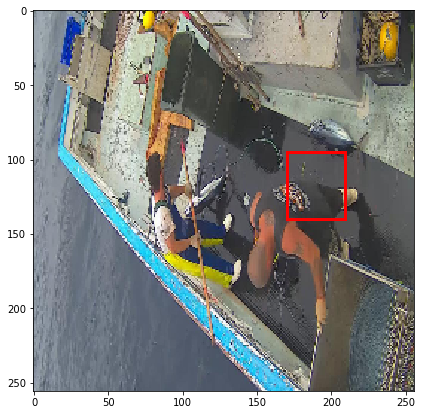

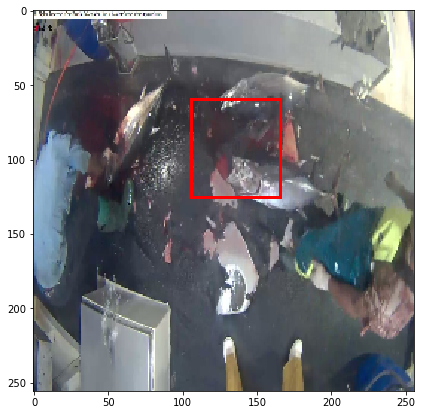

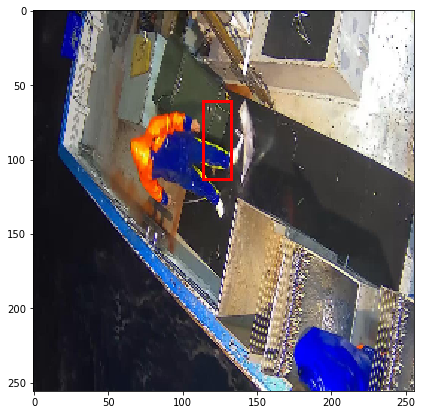

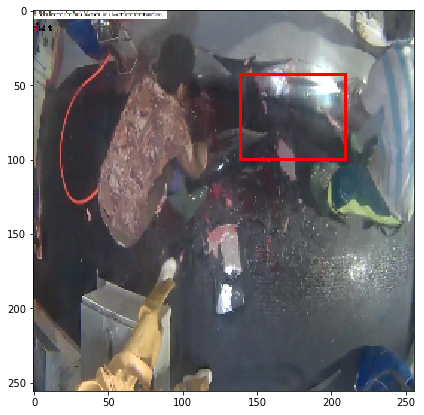

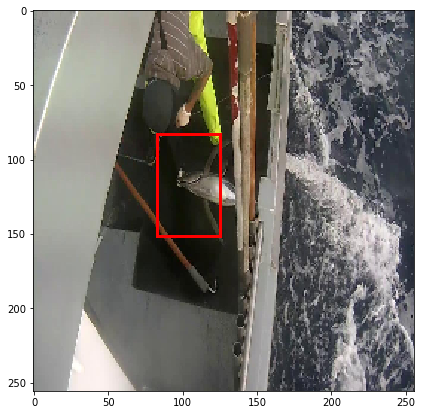

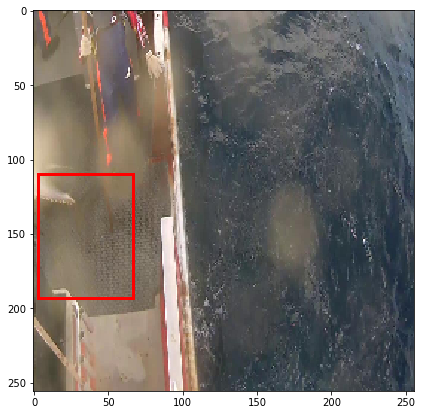

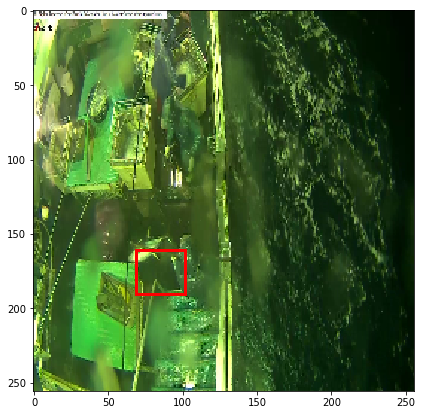

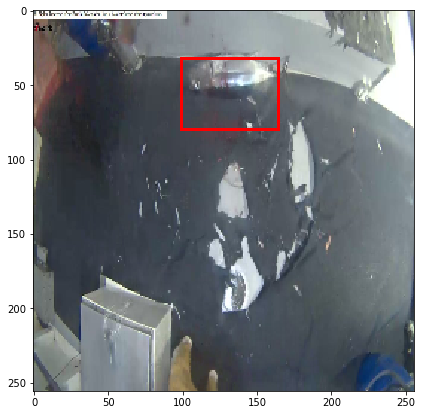

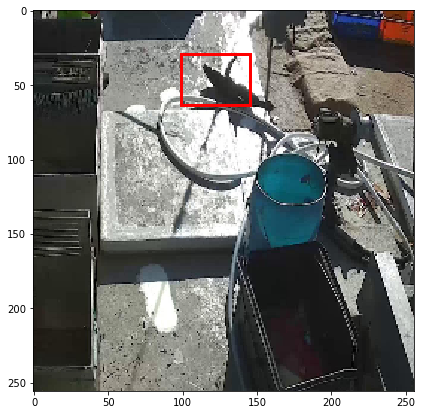

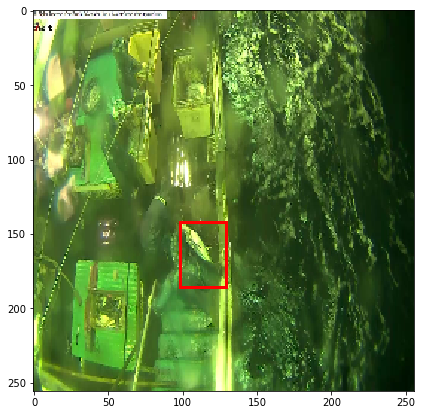

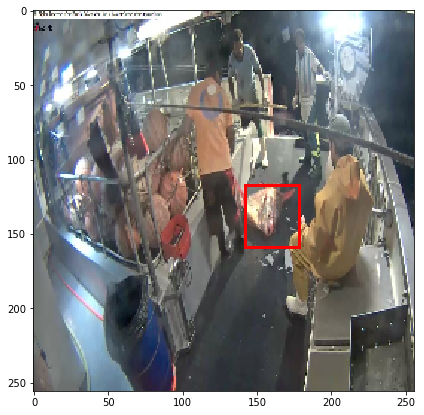

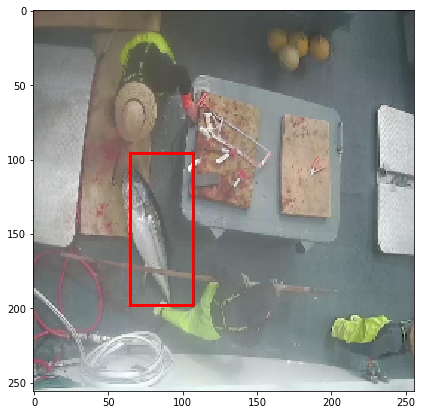

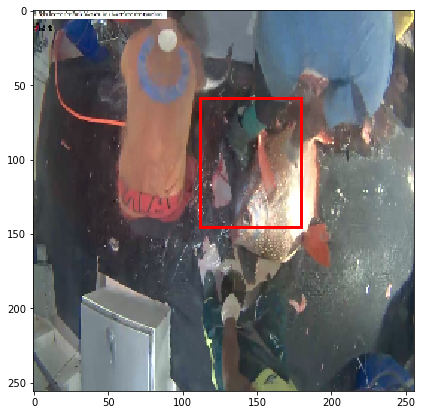

In [87]:
imgs, _ = next(val_gen)
pred_bboxes = model.predict(imgs)
for img, bbox in zip(imgs, pred_bboxes):
    visualize_bbox(img.transpose(1, 2, 0) + 0.5, bbox)

In [88]:
model.save('bbox_model.h5')